In [16]:
import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
import pyRAPL
from ultralytics import YOLO
from tqdm import tqdm

# Setup energy measurement
pyRAPL.setup()

# Paths
data_dir = Path("data/bdd100k")
images_dir = data_dir / "images" / "train"
models_dir = Path("models")
knowledge_dir = Path("knowledge")

# Load current model name
with open(knowledge_dir / "model.csv") as f:
    current_model = f.read().strip()

model_path = models_dir / f"{current_model}.pt"
print(f"📌 Using model: {current_model} ({model_path})")


📌 Using model: yolo_n (models/yolo_n.pt)


In [9]:
def run_inference(model, start_idx, end_idx, tag="baseline"):
    files = sorted(images_dir.glob("*.jpg"))[start_idx:end_idx]
    confidences, times, energies = [], [], []

    for img_path in tqdm(files, desc=f"🔍 {tag} Inference"):
        meter = pyRAPL.Measurement("inference")
        meter.begin()
        t0 = time.perf_counter()
        results = model(img_path, verbose=False)
        t1 = time.perf_counter()
        meter.end()

        # Confidence: mean over detections or 0 if none
        if results[0].boxes.conf.numel() > 0:
            conf = results[0].boxes.conf.mean().item()
        else:
            conf = 0.0

        confidences.append(conf)
        times.append(t1 - t0)
        energies.append(meter.result.pkg[0])

    stats = {
        "tag": tag,
        "avg_conf": float(np.mean(confidences)),
        "avg_time": float(np.mean(times)),
        "avg_energy": float(np.mean(energies)),
    }
    print(f"📊 {tag} Results: {stats}")
    return stats


In [4]:
# Load baseline model
baseline_model = YOLO(str(model_path))

# Run inference
baseline_stats = run_inference(baseline_model, 40000, 50000, tag="baseline")


🔍 baseline Inference: 100%|██████████| 10000/10000 [01:15<00:00, 132.55it/s]

📊 baseline Results: {'tag': 'baseline', 'avg_conf': 0.5087045046776533, 'avg_time': 0.007332669929899294, 'avg_energy': 214235.4672}


In [17]:
import os
from pathlib import Path
import shutil

data_dir = Path("data/bdd100k")
images_dir = data_dir / "images/test"
labels_dir = data_dir / "labels/test"   # ✅ correct path

train_subset_dir = data_dir / "subset_train_10k20k"
eval_subset_dir = data_dir / "subset_eval_40k50k"

for subset_dir in [train_subset_dir, eval_subset_dir]:
    (subset_dir / "images").mkdir(parents=True, exist_ok=True)
    (subset_dir / "labels").mkdir(parents=True, exist_ok=True)

image_files = sorted(list(images_dir.glob("*.jpg")))

# --- Training subset (10k–20k)
for img in image_files[:1000]:
    shutil.copy(img, train_subset_dir / "images" / img.name)
    lbl = labels_dir / (img.stem + ".txt")
    if lbl.exists():
        shutil.copy(lbl, train_subset_dir / "labels" / lbl.name)

# --- Evaluation subset (40k–50k)
for img in image_files[10000:11000]:
    shutil.copy(img, eval_subset_dir / "images" / img.name)
    lbl = labels_dir / (img.stem + ".txt")
    if lbl.exists():
        shutil.copy(lbl, eval_subset_dir / "labels" / lbl.name)

print("✔ Created subsets with labels")
print(f"Train subset: {len(list((train_subset_dir / 'images').glob('*.jpg')))} images")
print(f"Train labels: {len(list((train_subset_dir / 'labels').glob('*.txt')))} labels")
print(f"Eval subset: {len(list((eval_subset_dir / 'images').glob('*.jpg')))} images")
print(f"Eval labels: {len(list((eval_subset_dir / 'labels').glob('*.txt')))} labels")


✔ Created subsets with labels
Train subset: 1000 images
Train labels: 1000 labels
Eval subset: 1000 images
Eval labels: 1000 labels


In [18]:
train_yaml = "bdd100k_train10k20k.yaml"
eval_yaml = "bdd100k_eval40k50k.yaml"

# with open(train_yaml, "w") as f:
#     f.write(f"""
# train: {str((train_subset_dir / "images").resolve())}
# val: {str((eval_subset_dir / "images").resolve())}
# nc: 10
# names: ["car", "bus", "truck", "person", "bike", "motor", "light", "sign", "train", "other"]
# """)

# with open(eval_yaml, "w") as f:
#     f.write(f"""
# train: {str((eval_subset_dir / "images").resolve())}
# val: {str((eval_subset_dir / "images").resolve())}
# nc: 10
# names: ["car", "bus", "truck", "person", "bike", "motor", "light", "sign", "train", "other"]
# """)

# print("✔ Wrote dataset YAMLs:")
# !cat {train_yaml}


In [20]:
from ultralytics import YOLO
import torch.nn as nn

# Load model choice
with open("knowledge/model.csv", "r") as f:
    chosen_model = f.read().strip()

model_path = f"base_models/{chosen_model}.pt"
model = YOLO(model_path)

# ---------------------------
# 🔒 Freeze backbone, unfreeze Detect head
# ---------------------------
# Freeze all
for p in model.model.parameters():
    p.requires_grad = False

# Unfreeze detect head(s)
unfrozen_params = 0
total_params = sum(p.numel() for p in model.model.parameters())
for name, module in model.model.named_modules():
    if module.__class__.__name__.lower() == "detect":
        for p in module.parameters():
            p.requires_grad = True
            unfrozen_params += p.numel()

trainable = sum(p.numel() for p in model.model.parameters() if p.requires_grad)
print(f"✅ Trainable parameters: {trainable}/{total_params} (Detect head only)")

# Train
model.train(
    data=train_yaml,
    epochs=2,
    imgsz=640,
    batch=4,
    pretrained=True,
    mosaic=0.0,
    mixup=0.0,
    cache='disk'
)

# Save retrained model
retrained_model_path = f"models/{chosen_model}_retrained.pt"
model.save(retrained_model_path)
print(f"✔ Retrained model saved to {retrained_model_path}")


✅ Trainable parameters: 897664/3157200 (Detect head only)
Ultralytics 8.3.108 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
engine/trainer: task=detect, mode=train, model=base_models/yolo_n.pt, data=bdd100k_train10k20k.yaml, epochs=2, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=disk, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning /home/shaunak/src/research/sustainable-mlops/HarmonEXT/data/bdd100k/subset_train_10k20k/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

train: 3.9GB disk space required, with 50% safety margin but only 2.1/94.2GB free, not caching images to disk ⚠️



val: Scanning /home/shaunak/src/research/sustainable-mlops/HarmonEXT/data/bdd100k/subset_eval_40k50k/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/shaunak/src/research/sustainable-mlops/HarmonEXT/data/bdd100k/subset_eval_40k50k/images/e6f10c58-c46de527.jpg: 1 duplicate labels removed
val: 3.9GB disk space required, with 50% safety margin but only 2.1/94.2GB free, not caching images to disk ⚠️


Plotting labels to runs/detect/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train15
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      1.52G      1.734      2.053      1.176         43        640: 100%|██████████| 250/250 [00:10<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:03<00:00, 34.99it/s]


                   all       1000      18231      0.315      0.214      0.179      0.095

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.52G      1.636      1.362      1.114         58        640: 100%|██████████| 250/250 [00:09<00:00, 26.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:03<00:00, 34.48it/s]


                   all       1000      18231      0.349      0.232      0.208      0.112

2 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train15/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train15/weights/best.pt, 6.5MB

Validating runs/detect/train15/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:03<00:00, 32.79it/s]


                   all       1000      18231       0.35      0.232      0.209      0.112
                person        334       1281       0.36        0.4      0.359      0.169
               bicycle         67        106      0.555       0.16      0.199     0.0914
                   car        987      10181      0.388      0.578      0.528      0.302
            motorcycle         39         53       0.41     0.0755      0.147     0.0725
              airplane        127        157      0.204     0.0955     0.0724      0.058
                   bus        247        359      0.311      0.267      0.157      0.113
                 train        569       2768      0.327     0.0918     0.0834     0.0266
                 truck        837       3326      0.247      0.186      0.124     0.0619
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train15
✔ Retrained model saved to models/yolo_n_retrained.pt


In [19]:
with open("knowledge/model.csv", "r") as f:
    chosen_model = f.read().strip()
retrained_model_path = f"models/{chosen_model}_retrained.pt"
newmodel = YOLO(str(retrained_model_path))

# Run inference
baseline_stats = run_inference(newmodel, 2000, 3000, tag="retrained")



🔍 retrained Inference: 100%|██████████| 1000/1000 [00:07<00:00, 140.41it/s]

📊 retrained Results: {'tag': 'retrained', 'avg_conf': 0.5338009614944458, 'avg_time': 0.0068930183759948705, 'avg_energy': 189688.173}


In [22]:
import hashlib

def hash_file(path):
    hasher = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hasher.update(chunk)
    return hasher.hexdigest()

file1 = "models/yolo_m.pt"
file2 = "semi_base_models/yolo_m.pt"

if hash_file(file1) == hash_file(file2):
    print("✅ Files are identical")
else:
    print("❌ Files differ")


✅ Files are identical


1. Loading saved histogram from: versionedMR/yolo_m_v4_hist.json
   ✅ Successfully loaded.

2. Defining image window from directory: data/bdd100k/images/train
   ✅ Window defined: 1000 images from index 59500 to 60499.

3. Calculating average histogram for the image window...


Processing images:   0%|          | 0/1000 [00:00<?, ?it/s]

   ✅ Calculation complete.

4. Computing KL Divergence...
   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
   📊 KL Divergence(Current Window || Saved Histogram) = 0.0228
   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

5. Plotting distributions for comparison...


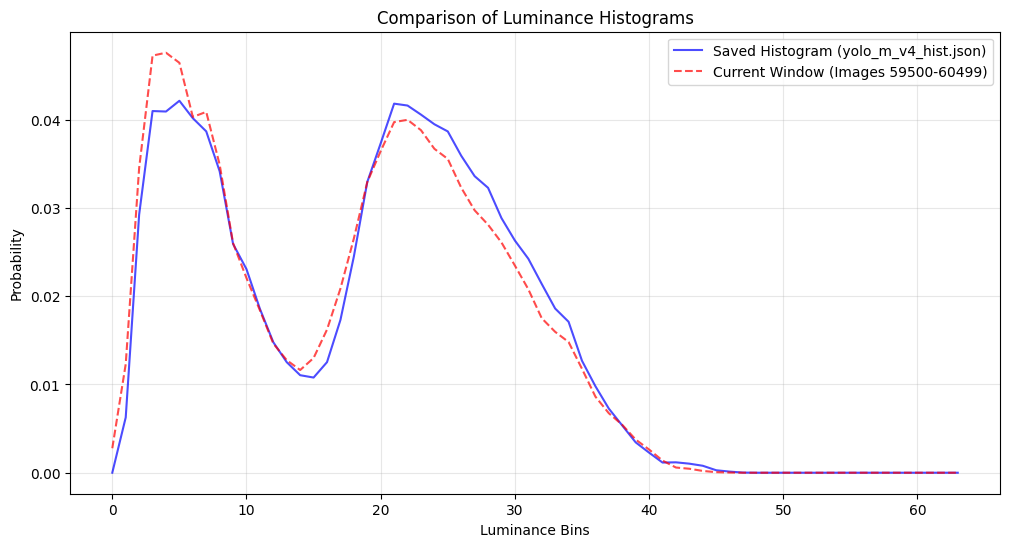

In [14]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
from scipy.stats import entropy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# ====================================================================
#                          CONFIGURATION
# ====================================================================

# 1. Set the path to the saved JSON histogram file
SAVED_HISTOGRAM_PATH = Path("versionedMR/yolo_m_v4_hist.json")

# 2. Set the path to the directory with the 70,000 augmented images
IMAGE_DIRECTORY = Path("data/bdd100k/images/train")

# 3. Set the starting index (N) for the 1000-image window
START_INDEX_N = 59500 # Example: Check the window starting at image 36,000

# ====================================================================
#                           HELPER FUNCTIONS
# ====================================================================

def luminance_histogram(img_path, bins=64):
    """Computes the luminance histogram for a single image."""
    try:
        with Image.open(img_path).convert("RGB") as im:
            arr = np.asarray(im, dtype=np.float32)
            y = 0.299 * arr[..., 0] + 0.587 * arr[..., 1] + 0.114 * arr[..., 2]
            y = np.clip(y, 0, 255)
            hist, _ = np.histogram(y, bins=bins, range=(0, 255), density=False)
            hist = hist.astype(np.float64)
            hist += 1e-12  # Additive smoothing to prevent zeros
            return hist / hist.sum()
    except Exception as e:
        # print(f"Warning: Could not process {img_path}. Error: {e}")
        return None

def kl_divergence(p, q):
    """Calculates KL(p || q)."""
    p = np.asarray(p) + 1e-12
    q = np.asarray(q) + 1e-12
    return entropy(p, q)

# ====================================================================
#                                MAIN LOGIC
# ====================================================================

# --- Step 1: Load the saved histogram ---
print(f"1. Loading saved histogram from: {SAVED_HISTOGRAM_PATH}")
try:
    with open(SAVED_HISTOGRAM_PATH, 'r') as f:
        data = json.load(f)
    saved_hist_dist = np.array(data["average_histogram"])
    print("   ✅ Successfully loaded.")
except FileNotFoundError:
    print(f"   ❌ ERROR: File not found at {SAVED_HISTOGRAM_PATH}. Please check the path.")
    # Stop execution if the file doesn't exist
    raise

# --- Step 2: Load image paths and define the window ---
print(f"\n2. Defining image window from directory: {IMAGE_DIRECTORY}")
all_image_paths = sorted(list(IMAGE_DIRECTORY.glob("*.jpg")))
window_size = 1000
end_index = START_INDEX_N + window_size

if START_INDEX_N >= len(all_image_paths) or end_index > len(all_image_paths):
    print(f"   ❌ ERROR: The requested window [{START_INDEX_N}:{end_index}] is out of bounds.")
    print(f"      The directory contains only {len(all_image_paths)} images.")
    raise IndexError("Image window is out of bounds.")

image_window_paths = all_image_paths[START_INDEX_N:end_index]
print(f"   ✅ Window defined: {len(image_window_paths)} images from index {START_INDEX_N} to {end_index - 1}.")

# --- Step 3: Calculate the average histogram for the image window ---
print("\n3. Calculating average histogram for the image window...")
window_hists = [h for p in tqdm(image_window_paths, desc="Processing images") if (h := luminance_histogram(p)) is not None]

if not window_hists:
    print("   ❌ ERROR: Could not calculate any histograms for the specified image window.")
    raise ValueError("No valid images found in the window.")

current_window_dist = np.mean(np.array(window_hists), axis=0)
print("   ✅ Calculation complete.")

# --- Step 4: Compute and display the KL Divergence ---
print("\n4. Computing KL Divergence...")
kl_div = kl_divergence(current_window_dist, saved_hist_dist)
print("   ---" * 10)
print(f"   📊 KL Divergence(Current Window || Saved Histogram) = {kl_div:.4f}")
print("   ---" * 10)

# --- Step 5 (Optional): Visualize the distributions ---
print("\n5. Plotting distributions for comparison...")
plt.figure(figsize=(12, 6))
plt.plot(saved_hist_dist, label=f'Saved Histogram ({SAVED_HISTOGRAM_PATH.name})', color='blue', alpha=0.7)
plt.plot(current_window_dist, label=f'Current Window (Images {START_INDEX_N}-{end_index-1})', color='red', linestyle='--', alpha=0.7)
plt.title('Comparison of Luminance Histograms')
plt.xlabel('Luminance Bins')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()